In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import json
from pathlib import Path

from cupbearer import data, detectors, models, scripts, tasks, utils
from tensorboard import notebook

/Users/oliverdaniels-koch/miniforge3/envs/cupbearer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'DataFormat' from partially initialized module 'cupbearer.data' (most likely due to a circular import) (/Users/oliverdaniels-koch/projects/cupbearer/src/cupbearer/data/__init__.py)

# Training a backdoored classifier
First, we train a classifier on poisoned data:

In [10]:
scripts.train_classifier(
    scripts.TrainClassifierConfig(
        path=Path("logs/demo/classifier"),
        model=models.MLPConfig(hidden_dims=[128, 128]),
        train_data=data.BackdoorData(
            # Poison 5% of the training data
            original=data.MNIST(),
            backdoor=data.CornerPixelBackdoor(p_backdoor=0.05),
        ),
        val_data={
            "clean": data.MNIST(train=False),
            "backdoor": data.BackdoorData(
                # By default, the poison rate is 100%, so this will let us evaluate
                # performance on completely poisoned data
                original=data.MNIST(train=False),
                backdoor=data.CornerPixelBackdoor(),
            ),
        },
        train_config=utils.TrainConfig(num_epochs=5, pbar=True),
    )
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/erik/.pyenv/versions/3.10.9/envs/cupbearer/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory logs/demo/classifier/checkpoints exists and is not empty.

  | Name           | Type               | Params
------------------------------------------------------
0 | model          | MLP                | 118 K 
1 | train_accuracy | MulticlassAccuracy | 0     
2 | val_accuracy   | ModuleList         | 0     
3 | test_accuracy  | ModuleList         | 0     
------------------------------------------------------
118 K     Trainable params
0         Non-trainable params
118 K     Total params
0.473     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/erik/.pyenv/versions/3.10.9/envs/cupbearer/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/erik/.pyenv/versions/3.10.9/envs/cupbearer/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


The training script will have automatically created Tensorboard log files. The model should be close to perfect on backdoored inputs, and decent (~95%) on clean data.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/demo

In [11]:
notebook.display(port=6006, height=1000)

Selecting TensorBoard with logdir logs/demo (started 0:11:31 ago; port 6006, pid 93984).


We can also explicitly evaluate the trained model (right now this is pretty limited and doesn't support multiple datasets at once):

In [13]:
scripts.eval_classifier(
    scripts.EvalClassifierConfig(
        path=Path("logs/demo/classifier"), data=data.MNIST(train=False)
    )
)

2024-02-14 14:33:59.006 | DEBUG    | cupbearer.scripts.eval_classifier:main:18 - Loading transform: ToTensor()
2024-02-14 14:33:59.006 | DEBUG    | cupbearer.scripts.eval_classifier:main:18 - Loading transform: RandomCrop(p=0.8, padding=5, fill=0, padding_mode='constant')
2024-02-14 14:33:59.007 | DEBUG    | cupbearer.scripts.eval_classifier:main:18 - Loading transform: RandomRotation(p=0.5, degrees=10, interpolation=<InterpolationMode.NEAREST: 'nearest'>, expand=False, center=None, fill=0)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test/acc_epoch       │    0.9509999752044678     │
│       test/acc_step       │    0.9509999752044678     │
│         test/loss         │    0.15841300785541534    │
└───────────────────────────┴───────────────────────────┘

These results will also have been stored to `logs/demo/classifier/metrics.json` if we want to process them further (e.g. to compare many runs):

In [14]:
with open("logs/demo/classifier/eval.json") as f:
    print(json.load(f))

[{'test/loss': 0.15841300785541534, 'test/acc_step': 0.9509999752044678, 'test/acc_epoch': 0.9509999752044678}]


# Training a backdoor detector
We'll train a very simple detector using the Mahalanobis distance:

2024-02-14 14:39:19.332 | DEBUG    | cupbearer.utils.scripts:load_config:55 - Loading config 'train_data' from logs/demo/classifier
2024-02-14 14:39:19.356 | DEBUG    | cupbearer.utils.scripts:load_config:55 - Loading config 'model' from logs/demo/classifier
100%|██████████| 15/15 [00:06<00:00,  2.32it/s]
2024-02-14 14:39:26.325 | INFO     | cupbearer.detectors.anomaly_detector:save_weights:205 - Saving detector to logs/demo/detector/detector
2024-02-14 14:39:26.360 | DEBUG    | cupbearer.utils.scripts:load_config:55 - Loading config 'model' from logs/demo/classifier
2024-02-14 14:39:26.375 | DEBUG    | cupbearer.utils.scripts:load_config:55 - Loading config 'detector' from logs/demo/detector
2024-02-14 14:39:26.378 | INFO     | cupbearer.detectors.anomaly_detector:load_weights:209 - Loading detector from logs/demo/detector/detector
2024-02-14 14:39:28.636 | INFO     | cupbearer.detectors.anomaly_detector:eval:128 - AUC_ROC: 1.0000
2024-02-14 14:39:28.636 | INFO     | cupbearer.detecto

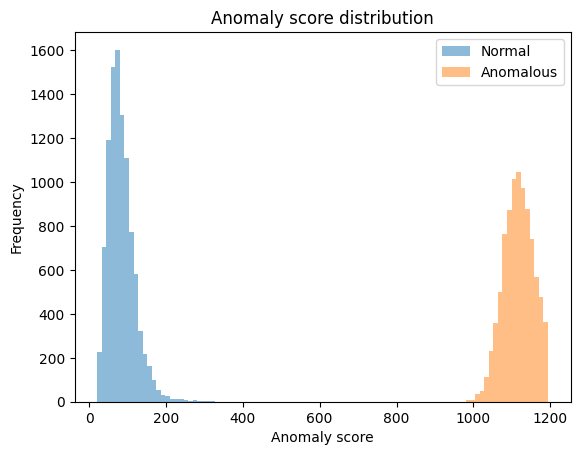

In [3]:
scripts.train_detector(
    scripts.TrainDetectorConfig(
        path=Path("logs/demo/detector"),
        task=tasks.BackdoorDetection(
            # We pass in the path of the trained classifier, as well as what backdoor
            # to use. The backdoor is the same one we used for training in this case,
            # we could also have stored that.
            path=Path("logs/demo/classifier"),
            backdoor=data.CornerPixelBackdoor(),
        ),
        detector=detectors.MahalanobisConfig(),
    )
)

As we can see, this was a trivial detection task. As an ablation, we can test whether the detector specifically flags backdoored inputs as anomalous, or just anything out of distribution:

2024-02-14 19:38:05.113 | DEBUG    | cupbearer.utils.scripts:load_config:55 - Loading config 'model' from logs/demo/classifier
2024-02-14 19:38:05.132 | DEBUG    | cupbearer.utils.scripts:load_config:55 - Loading config 'detector' from logs/demo/detector
2024-02-14 19:38:05.135 | INFO     | cupbearer.detectors.anomaly_detector:load_weights:209 - Loading detector from logs/demo/detector/detector
2024-02-14 19:38:07.769 | INFO     | cupbearer.detectors.anomaly_detector:eval:128 - AUC_ROC: 0.9998
2024-02-14 19:38:07.770 | INFO     | cupbearer.detectors.anomaly_detector:eval:129 - AP: 0.9994


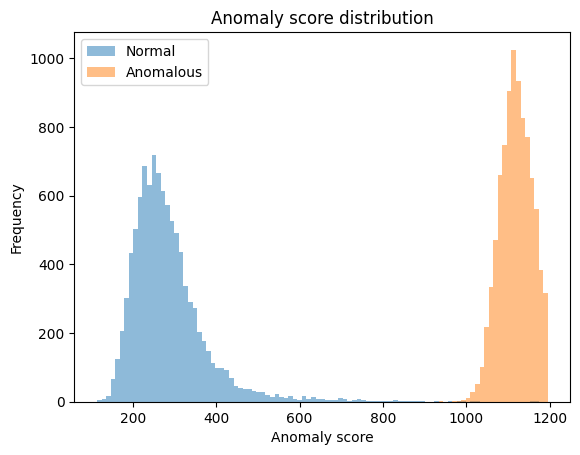

In [7]:
scripts.eval_detector(
    scripts.EvalDetectorConfig(
        path=Path("logs/demo/detector"),
        task=tasks.CustomTask(
            # TODO: this won't actually be used, plausibly Tasks should be split better
            # into their training and test data.
            train_data=data.MNIST(),
            # Our anomalous data is the backdoor data from above, except we use the
            # MNIST test split.
            anomalous_data=data.BackdoorData(
                original=data.MNIST(train=False),
                backdoor=data.CornerPixelBackdoor(),
            ),
            # Our normal data is MNIST with added noise, this makes the images OOD
            # but they shouldn't be mechanistically anomalous.
            normal_test_data=data.MNIST(
                train=False,
                transforms={
                    "to_tensor": data.ToTensor(),
                    "noise": data.GaussianNoise(0.3),
                },
            ),
            model=models.StoredModel(Path("logs/demo/classifier")),
        ),
    )
)

As we can see, adding noise did make the images quite a bit more "anomalous" according to our detector (the blue histogram has shifted to the right to higher anomaly scores). But we still have a very clear separation between these "merely noisy" inputs and the backdoored inputs. (This is a very easy to detect backdoor.)